In [1]:
import random
from pathlib import Path

import graphix.command
import numpy as np
import stim
import veriphix.client
from graphix.fundamentals import IXYZ
from graphix.noise_models import DepolarisingNoiseModel, NoiseModel
from graphix.pauli import Pauli
from graphix.random_objects import Circuit, rand_circuit
from graphix.sim.density_matrix import DensityMatrixBackend
from graphix.sim.statevec import Statevec, StatevectorBackend
from graphix.states import BasicStates
from veriphix.client import CircuitUtils, Client, Secrets, TrappifiedCanvas
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

import gospel.brickwork_state_transpiler
from gospel.scripts.qasm2brickwork_state import read_qasm, draw_brickwork_state_colormap

/Users/sabdulsa/Codes/gospel/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/sabdulsa/Codes/gospel/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/sabdulsa/Codes/gospel/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [3]:
## Load a circuit with success probability p = 0.7839549798834848
# BQP error
# context handler open renvoie f et à la fin ferme le fichier
# valeur à durer de vie, resource libéré.

with Path("circuits/circuit000.qasm").open() as f:
    circuit = read_qasm(f)

print(circuit.instruction)

pattern = gospel.brickwork_state_transpiler.transpile(circuit)

print(list(pattern))


## Measure output nodes, to have classical output
classical_output = pattern.output_nodes
for onode in classical_output:
    pattern.add(graphix.command.M(node=onode))

states = [BasicStates.PLUS] * len(pattern.input_nodes)

# correct since the pattern is transpiled from a circuit and hence has a causal flow
pattern.minimize_space()

print(f"Number of nodes in the pattern : {pattern.n_node}")


[CNOT(target=3, control=2), RX(target=2, angle=0.7853981633974483, meas_index=None), RX(target=3, angle=0.7853981633974483, meas_index=None), RZ(target=3, angle=0.7853981633974483, meas_index=None), CNOT(target=2, control=1), RZ(target=2, angle=5.497787143782138, meas_index=None), RX(target=3, angle=1.5707963267948966, meas_index=None), CNOT(target=2, control=3), CNOT(target=2, control=1), CNOT(target=0, control=1), CNOT(target=1, control=2)]
[N(node=4), E(nodes=(0, 4)), M(node=0), X(node=4, domain={0}), N(node=5), E(nodes=(1, 5)), M(node=1), X(node=5, domain={1}), N(node=6), E(nodes=(2, 6)), M(node=2), X(node=6, domain={2}), N(node=7), E(nodes=(3, 7)), M(node=3), X(node=7, domain={3}), N(node=8), E(nodes=(4, 8)), M(node=4), X(node=8, domain={4}), N(node=9), E(nodes=(5, 9)), M(node=5), X(node=9, domain={5}), N(node=10), E(nodes=(6, 10)), M(node=6), X(node=10, domain={6}), N(node=11), E(nodes=(7, 11)), M(node=7,angle=0.5), X(node=11, domain={7}), E(nodes=(8, 9)), N(node=12), E(nodes=(8,

In [11]:
def load_pattern_from_circuit(circuit_label:str):
    with Path(f"circuits/{circuit_label}").open() as f:
        circuit = read_qasm(f)
        pattern = gospel.brickwork_state_transpiler.transpile(circuit)

        ## Measure output nodes, to have classical output
        classical_output = pattern.output_nodes
        for onode in classical_output:
            pattern.add(graphix.command.M(node=onode))

        states = [BasicStates.PLUS] * len(pattern.input_nodes)

        # correct since the pattern is transpiled from a circuit and hence has a causal flow
        pattern.minimize_space()
    return pattern, classical_output

pattern, onodes = load_pattern_from_circuit("circuit000.qasm")
print(onodes)

[160, 161, 162, 163]


### Filter circuits

In [5]:
import json
from pathlib import Path
with Path("circuits/table.json").open() as f:
    table = json.load(f)
    circuits = [name for name,prob in table.items() if prob < 0.2]
    print(len(circuits))

353


### Defining global noise model

In [6]:
"""Global noise model."""

from __future__ import annotations

from typing import TYPE_CHECKING

import typing_extensions

from graphix.channels import KrausChannel, dephasing_channel
from graphix.command import Command, CommandKind, BaseM
from graphix.noise_models.noise_model import Noise, NoiseModel, NoiseCommands, CommandOrNoise
from graphix.rng import ensure_rng
import random


if TYPE_CHECKING:
    from numpy.random import Generator


class GlobalNoiseModel(NoiseModel):
    """Global noise model.

    :param NoiseModel: Parent abstract class class:`graphix.noise_model.NoiseModel`
    :type NoiseModel: class
    """

    def __init__(
        self,
        nodes: list[int],
        prob: float = 0.0,
        rng: Generator = None,
    ) -> None:
        self.prob = prob
        self.nodes = nodes
        self.node = random.choice(self.nodes)
        self.rng = ensure_rng(rng)

    def refresh_randomness(self):
        self.node = random.choice(self.nodes)

    def input_nodes(self, nodes: list[int]) -> NoiseCommands:
        """Return the noise to apply to input nodes."""
        return []

    def command(self, cmd: CommandOrNoise) -> NoiseCommands:
        """Return the noise to apply to the command `cmd`."""
        return [cmd]

    def confuse_result(self, cmd:BaseM, result: bool) -> bool:
        """Assign wrong measurement result cmd = "M"."""
        if cmd.node == self.node and self.rng.uniform() < self.prob:
            return not result
        else:
            return result
    


### Here comes **Veriphix**

#### Test rounds
Setting up the client, the simulation, tests rounds, plotting

In [28]:
secrets = Secrets(r=True, a=True, theta=True)
client = Client(pattern=pattern, secrets=secrets)

# define test runs using a greedy colouring algorithm
# test_runs =  client.create_test_runs()
# for i in test_runs:
#     print(i.traps_list)

# checking new feature of veriphix
# don't use heuristic color-finding but use the optimal one (bipartite)
colours = gospel.brickwork_state_transpiler.get_bipartite_coloring(pattern) 
test_runs =  client.create_test_runs(manual_colouring=colours)

# for j, i in enumerate(test_runs):
#     print(j)
#     print(i.traps_list)

# Insert noise here 
noise = DepolarisingNoiseModel(entanglement_error_prob=0.1)
noise = GlobalNoiseModel(prob=1, nodes=range(pattern.n_node))

backend = DensityMatrixBackend()

n_failures = 0
n_iterations = 10

# print(test_runs[0].traps_list)  # test_runs

# list n_iteration : list of traps (nodes) that returned one
test_outcome_table = []

for _ in range(n_iterations):
    run = TrappifiedCanvas(random.choice(test_runs))
    # Change noisy qubit at each iteration (choose randomly)
    # noise.refresh_randomness()
    # print(run.traps_list)
    trap_outcomes = client.delegate_test_run(
        run=run, backend=backend, noise_model=noise
    )
    # print(trap_outcomes)
    result = {
        trap: outcome for (trap,), outcome in zip(run.traps_list, trap_outcomes)
    }  # extrait un elet de la structure virgule nécessair epour vérifier un seul élément, ou next(iter(trap))
    # both are in same order
    test_outcome_table.append(result)

    if sum(trap_outcomes) != 0:
        n_failures += 1
        print("Failed trap round")
    else:
        print("Trap round passed")

print(f"Number of failed rounds: {n_failures}/{n_iterations}")

Failed trap round
Failed trap round
Failed trap round
Failed trap round
Failed trap round
Failed trap round
Failed trap round
Trap round passed
Failed trap round
Failed trap round
Number of failed rounds: 9/10


### Plotting distribution of trap round failure rate
- For $N$ instances ($N$ different circuits)
  - Run 100 test runs with a given global noise model
  - plot the fraction of failed test rounds

In [17]:
threshold, p_err = 0.2, 0.6
threshold, p_err = 0.1, 0.6
threshold, p_err = 0.2, 0.6
threshold, p_err = 0.1, 0.1

# Recording info
fail_rates = []
decision_dict = {}
outcomes_dict = {}

# Fixed parameters
d = 20       # nr of computation rounds
t = 10      # nr of test rounds
N = d + t   # nr of total rounds
num_instances = 10
instances = random.sample(circuits, num_instances)


backend = DensityMatrixBackend()

for circuit in instances:
    # Generate a different instance
    pattern, onodes = load_pattern_from_circuit(circuit)

    # Instanciate Client and create Test runs
    client = Client(pattern=pattern, secrets=Secrets(a=True, r=True, theta=True))
    colours = gospel.brickwork_state_transpiler.get_bipartite_coloring(pattern) 
    test_runs =  client.create_test_runs(manual_colouring=colours)

    outcome_sum = 0
    # Trappified scheme parameters

    rounds = list(range(N))
    random.shuffle(rounds)

    n_failed_trap_rounds = 0
    n_tolerated_failures = threshold*t

    noise_model = GlobalNoiseModel(prob=p_err, nodes=range(pattern.n_node))
    for i in rounds:
        if i < d:
            # Computation round
            client.delegate_pattern(backend=backend, noise_model=noise_model)
            outcome_sum += client.results[onodes[0]]
        else:
            # Test round
            run = TrappifiedCanvas(random.choice(test_runs))
            trap_outcomes = client.delegate_test_run(run=run, backend=backend, noise_model=noise_model)
            noise_model.refresh_randomness()

            # Record trap failure
            # A trap round fails if one of the single-qubit traps failed
            if sum(trap_outcomes) != 0:
                n_failed_trap_rounds += 1
    if n_failed_trap_rounds > n_tolerated_failures :
        # reject instance
        # do nothing
        decision_dict[circuit] = 0
        pass
    else:
        # accept instance
        decision_dict[circuit] = 1
        # compute majority vote
        if outcome_sum == d/2:
            raise ValueError("Ambiguous result")
        outcome = int(outcome_sum > d/2)
        outcomes_dict[circuit] = outcome

    fail_rates.append(n_failed_trap_rounds/t)


expected = p_err/len(test_runs)


Generating the plot

In [18]:
print(outcomes_dict)
print(decision_dict)

{'circuit402.qasm': 1, 'circuit488.qasm': 0, 'circuit193.qasm': 0, 'circuit307.qasm': 1, 'circuit209.qasm': 1, 'circuit105.qasm': 1, 'circuit892.qasm': 0}
{'circuit402.qasm': 1, 'circuit488.qasm': 1, 'circuit193.qasm': 1, 'circuit307.qasm': 1, 'circuit954.qasm': 0, 'circuit209.qasm': 1, 'circuit105.qasm': 1, 'circuit252.qasm': 0, 'circuit892.qasm': 1, 'circuit152.qasm': 0}


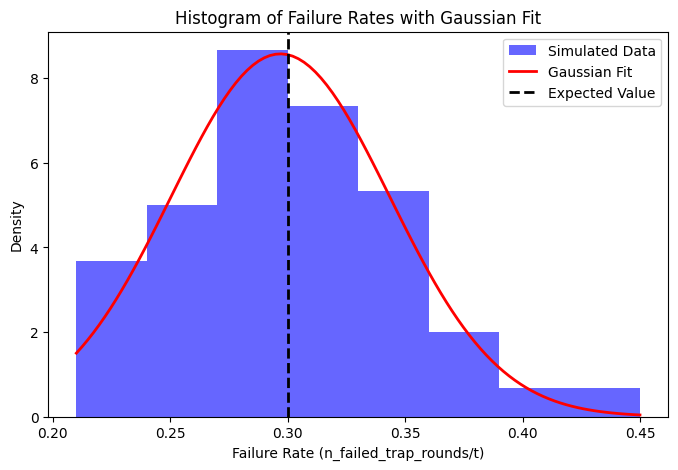

In [65]:
# Compute expected value
expected = p_err / len(test_runs)  # Assuming 10 single-qubit traps per test round

# Plot histogram
plt.figure(figsize=(8, 5))
counts, bins, _ = plt.hist(fail_rates, bins=8, density=True, alpha=0.6, color='b', label='Simulated Data')

# Fit Gaussian curve
mu, std = norm.fit(fail_rates)
x = np.linspace(min(bins), max(bins), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r-', linewidth=2, label='Gaussian Fit')

# Vertical line for expected value
plt.axvline(expected, color='k', linestyle='dashed', linewidth=2, label='Expected Value')

plt.xlabel('Failure Rate (n_failed_trap_rounds/t)')
plt.ylabel('Density')
plt.title('Histogram of Failure Rates with Gaussian Fit')
plt.legend()
plt.show()

### Plotting the trap failure data
Working on the output first...

In [29]:
print(len(test_outcome_table))
occurences = {}
occurences_one = {}

for results in test_outcome_table:
    for q, r in results.items():
        if q not in occurences:
            occurences[q] = 1
            occurences_one[q] = r
        else:
            occurences[q] += 1
            if r == 1:
                occurences_one[q] += 1

failure_proba = {q: occurences_one[q] / occurences[q] for q in occurences}
print(failure_proba)


10
{0: np.float64(0.0), 2: np.float64(0.0), 4: np.float64(0.0), 7: np.float64(0.0), 9: np.float64(0.0), 11: np.float64(0.0), 12: np.float64(0.0), 14: np.float64(0.0), 16: np.float64(0.0), 19: np.float64(0.0), 21: np.float64(0.0), 23: np.float64(0.0), 24: np.float64(0.0), 26: np.float64(0.0), 28: np.float64(0.0), 31: np.float64(0.0), 33: np.float64(0.0), 35: np.float64(0.0), 36: np.float64(0.0), 38: np.float64(0.0), 40: np.float64(0.0), 43: np.float64(0.0), 45: np.float64(0.0), 47: np.float64(0.0), 48: np.float64(0.0), 50: np.float64(0.0), 52: np.float64(0.0), 55: np.float64(0.0), 57: np.float64(0.0), 59: np.float64(0.0), 60: np.float64(0.0), 62: np.float64(0.0), 64: np.float64(0.0), 67: np.float64(0.0), 69: np.float64(0.0), 71: np.float64(0.0), 72: np.float64(0.0), 74: np.float64(0.0), 76: np.float64(0.0), 79: np.float64(0.0), 81: np.float64(0.0), 83: np.float64(0.0), 84: np.float64(0.0), 86: np.float64(0.0), 88: np.float64(0.0), 91: np.float64(0.0), 93: np.float64(0.0), 95: np.float64

FileNotFoundError: [Errno 2] No such file or directory: 'simulation/pic2.svg'

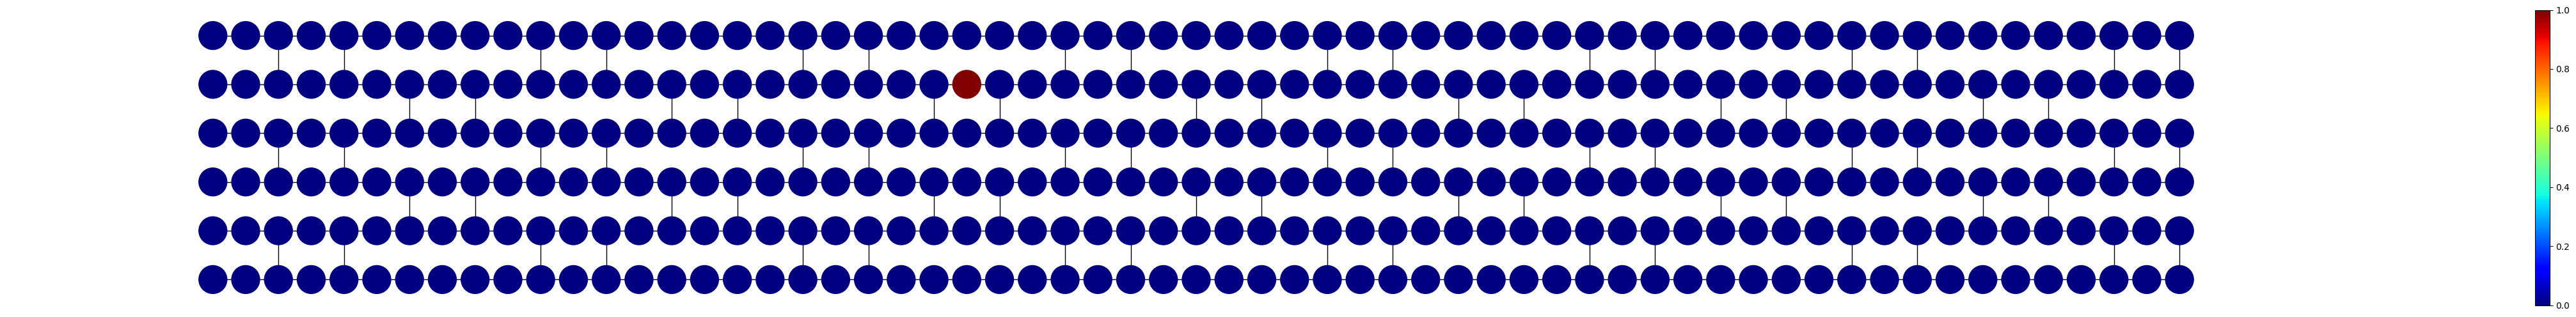

In [30]:
# change this to save the figure
path = Path("simulation/")
target = "pic2.svg"

draw_brickwork_state_colormap(circuit=circuit, target=path / target, failure_probas=failure_proba)

#### Full computation (computation and tests rounds)

todo

In [ ]:
def make_clifford(pattern: graphix.Pattern):
    clifford_pattern = graphix.Pattern(pattern.input_nodes)
    for cmd in pattern:
        clifford_pattern.add(cmd)
    for cmd in clifford_pattern:
        if cmd.kind == graphix.command.CommandKind.M:
            new_angle = random.choice([0, 1 / 2, 1, 3 / 2])
            cmd.angle = new_angle
    return clifford_pattern

In [ ]:
backend = DensityMatrixBackend()


# Noiseless computation run
client.delegate_pattern(backend=backend)
for onode in classical_output:
    print(client.results[onode])


# Noiseless trap run
noiseless_model = DepolarisingNoiseModel(entanglement_error_prob=0)
rd_run = random.choice(runs)
trap_outcomes = client.delegate_test_run(
    backend=backend, run=rd_run, noise_model=noiseless_model
)
print(
    f"Trap outcome of noiseless trap run: {sum(trap_outcomes)}"
)  # should output 0 (noiseless simulation)

# (ultra) Noisy trap run
ultra_noisy_model = DepolarisingNoiseModel(entanglement_error_prob=1)
rd_run = random.choice(runs)
trap_outcomes = client.delegate_test_run(
    backend=backend, run=rd_run, noise_model=ultra_noisy_model
)
print(
    f"Trap outcome of noisy trap run: {sum(trap_outcomes)}"
)  # should NOT output 0 (noisy simulation)
